Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [401]:
from random import random, seed
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from itertools import accumulate
from tqdm.auto import tqdm

#from icecream import ic

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [402]:
UNIVERSE_SIZE = 10000
NUM_SETS = 1000
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [403]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.power(SETS.sum(axis=1), 1.1)

## Helper Functions

In [404]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Have Fun!

In [405]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
valid(solution), cost(solution)

(True, 4279802.213534553)

In [406]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
valid(solution), cost(solution)

(True, 2140493.7499014093)

In [407]:

#mins_tab_cost = np.array([np.min(COSTS[SETS[:, k]]) for k in tqdm(range(SETS.shape[1])) ])
mins_tab_idxs = np.array([np.argmin( COSTS + (np.logical_not(SETS[:, k]) * UNIVERSE_SIZE**1.1) ) for k in tqdm(range(SETS.shape[1])) ])

100%|██████████| 10000/10000 [00:00<00:00, 206566.10it/s]


In [408]:
def get_inc_cost(sol):
    phenotype = np.logical_or.reduce(SETS[sol])
    idxs = np.unique(mins_tab_idxs[np.logical_not(phenotype)])
    return COSTS[idxs].sum()

def fix_solution(sol):
    phenotype = np.logical_or.reduce(SETS[sol])
    idxs = mins_tab_idxs[np.logical_not(phenotype)]
    for idx in idxs:
        sol[idx] = True

In [409]:
def evaluate(sol):
    return -(cost(sol) + get_inc_cost(sol))

In [410]:
def tweak(solution):
    
    new_solution = solution.copy()

    #new_solution[index] = not new_solution[index]

    step = 1
    for k in range(step):
        index1 = np.random.randint(0, NUM_SETS)
        index2 = index1
        while(new_solution[index1] == new_solution[index2]):
            index2 = np.random.randint(0, NUM_SETS)

        t = new_solution[index1]
        new_solution[index1] = new_solution[index2]
        new_solution[index2] = t
    
    
    #n = np.random.random()
    #if n < 0.05:
    #    new_solution[index1] = False
    

    
    #index = None
    #while index is None or np.random.random() < 0.4:
    #    index = np.random.randint(0, NUM_SETS)
    #    new_solution[index] = not new_solution[index]

    return new_solution

100%|██████████| 100000/100000 [00:12<00:00, 8242.55it/s]


False
-112484.90431065352
17
25
------------
True
112484.90431065352
0
27
------------
-112484.90431065352


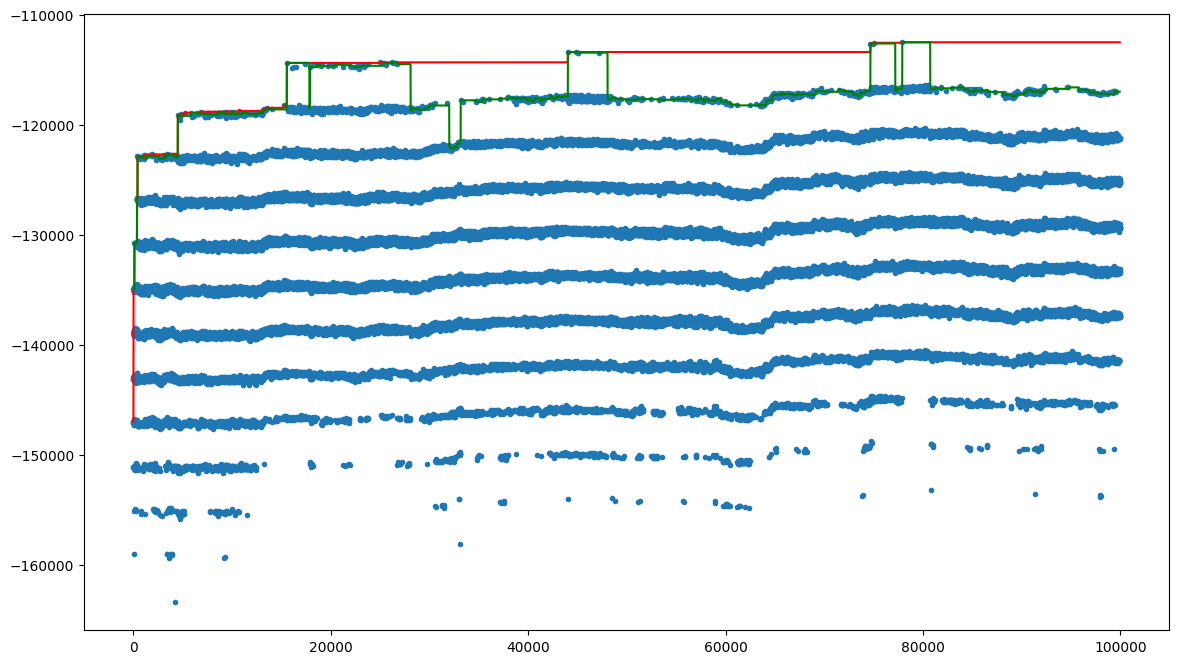

In [422]:

'''
100     10      .2
1000    100     .2      16
10000   1000    .2      25
100000  10000   .1      73
100000  10000   .2      37
100000  10000   .3      24
'''

solution = np.array([n < 25 for n in range(NUM_SETS)])#rng.random(NUM_SETS) < 0.024
np.random.shuffle(solution)
best_solution = solution

eval_sol = evaluate(solution)
eval_best_solution = eval_sol

history = []
historyLow = []
iter = 100000
dist = 0
not_wrong = 0
lower_eval = -np.inf

mean_cost = (UNIVERSE_SIZE * DENSITY) ** 1.1

for n in tqdm(range(iter)):
    # TWEAK!
    new_solution = tweak(solution)
    
    

    eval_new = evaluate(new_solution)
    #eval_sol = evaluate(solution)

    if n > 50:
        history.append(eval_new)
        historyLow.append(lower_eval)
    

    if eval_new > eval_sol:
        solution = new_solution
        eval_sol = eval_new
        if eval_sol > eval_best_solution:
            best_solution = solution
            eval_best_solution = eval_sol
    
    elif not_wrong == 0:
        t = mean_cost * (dist+1)/9000 
        p = np.exp(-(eval_sol-eval_new)/t)
        if(np.random.random() < p):
            solution = new_solution
            eval_sol = eval_new

            lower_eval = eval_new
            dist = 0
            #not_wrong = 8000

    if eval_sol > 0.99 * lower_eval:
        lower_eval = eval_sol
        dist = 0
    else:
        dist+=1

    if not_wrong > 0:
        not_wrong = not_wrong - 1

solution = best_solution.copy()

# That's all...
print(valid(solution))
print(evaluate(solution))
#print(history.index(evaluate(solution)))
print(UNIVERSE_SIZE - np.logical_or.reduce(SETS[solution]).sum())
print(solution.sum())
print("------------")


fix_solution(solution)


print(valid(solution))
print(cost(solution))
#print(history.index(evaluate(solution)))
print(UNIVERSE_SIZE - np.logical_or.reduce(SETS[solution]).sum())
print(solution.sum())
print("------------")
print(max(history))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
plt.plot(
    range(len(historyLow)),
    historyLow,
    color="green",
)
_ = plt.scatter(range(len(history)), history, marker=".")

None
